# EfficientNets

Minimalist implemantation of EfficientNets for classification.

The dataset used will be a subset of the Intel Scene Classification Challenge to keep it simple and colab-friendly, minor changes can be made to use any other dataset.


## [Paper](https://arxiv.org/abs/1905.11946)


In [ ]:
import time
import torch
import torchvision
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score
from torch.utils.data.dataloader import DataLoader

# Fix random seed
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")


Using cuda:0


## Dataset

In [ ]:
# Commands to download and prepare scene classification data from:
# https://drive.google.com/file/d/1XPoT-4enxMXer5ZWRXwCVR0W-fObkOhT/view?usp=sharing

! gdown --id 1XPoT-4enxMXer5ZWRXwCVR0W-fObkOhT --output scene_classification.zip

! unzip -q scene_classification.zip
! rm scene_classification.zip

Downloading...
From: https://drive.google.com/uc?id=1XPoT-4enxMXer5ZWRXwCVR0W-fObkOhT
To: /content/scene_classification.zip
100% 253M/253M [00:01<00:00, 171MB/s]
replace train_set/buildings/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
IMAGE_SIZE = 224

# Review transforms for other datasets
train_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomCrop(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(0.2),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
    ]
)

test_transform = transforms.Compose(
    [transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()]
)

train_images = ImageFolder(
    root="train_set", transform=train_transform
)

test_images = ImageFolder(
    root="test_set", transform=test_transform
)

classes = train_images.classes
N_CLASSES = len(classes)


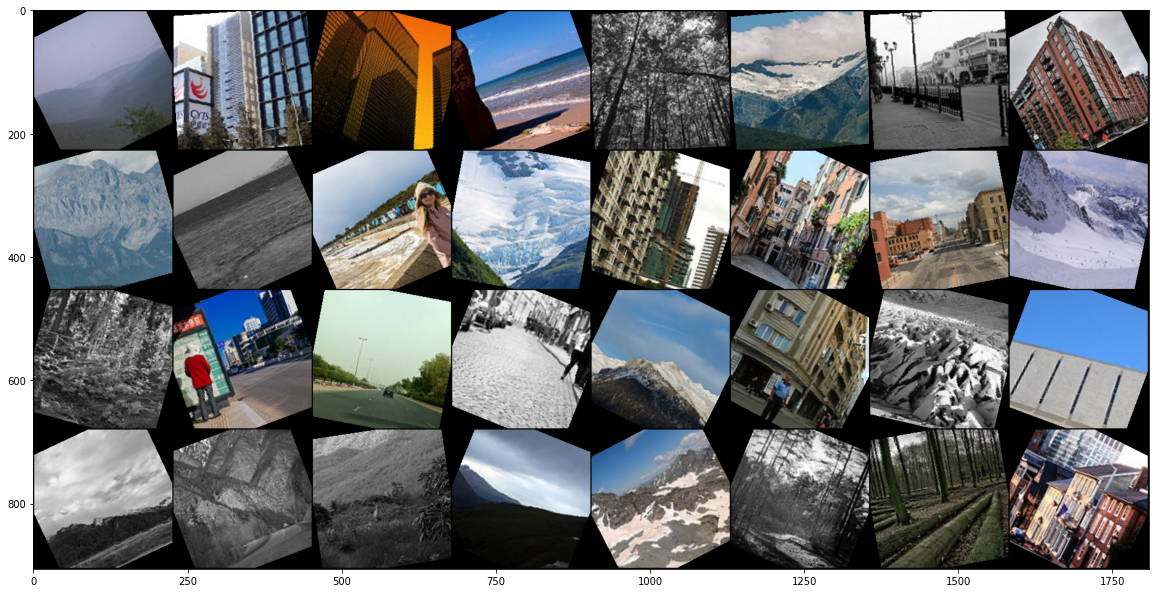

In [ ]:
# Show some images
def show_image(image, title):
    image = image.numpy().transpose((1, 2, 0))
    fig = plt.figure(figsize=(20, 20))
    plt.imshow(image)
    plt.title(title)
    plt.show()


# Get a batch of training data
example_images_loader = DataLoader(train_images, batch_size=32, shuffle=True)
sample, labels = next(iter(example_images_loader))

sample = torchvision.utils.make_grid(sample)
show_image(sample, title="")


## Model Definition




In [ ]:
class Swish(nn.Module):
  def forward(self, x):
    return x * torch.sigmoid(x)

In [ ]:
class MBConvBlock(nn.Module):
    """
    MobileNet Bottleneck Residual Block

    Parameters
    ----------
    kernel_size: int
      Size of convolutional kernel for depthwise conv operation.
    input_channels: int
      Number of input channels for the block.
    output_channels: int
      Number of output channels for the block.
    expand_ratio: float, default: 1.0
      Ratio to expand input channels before being squeezed back to block_channels.
    squeeze_ratio: float, default:0.2
      Ratio to squeeze expanded channels in squeeze and excitation layers.
    relu_six: bool, default: True
      Whether to use ReLU6 or ReLU as the block activation.
    """

    def __init__(
        self,
        kernel_size,
        input_channels,
        output_channels,
        stride=1, 
        expand_ratio=1.0,
        squeeze_ratio=0.2,
        relu_six=True,
    ):
        super(MBConvBlock, self).__init__()
        self.activation = nn.ReLU6() if relu_six else nn.ReLU()
        self.residual = input_channels == output_channels
        self.expand_channels = int(expand_ratio * input_channels)
        self.squeeze_channels = max(1, int(input_channels * squeeze_ratio))

        self.depthwise_layers = nn.Sequential(
            # Expand
            nn.Conv2d(
                in_channels=input_channels,
                out_channels=self.expand_channels,
                kernel_size=1,
            ),
            nn.BatchNorm2d(self.expand_channels),
            self.activation,
            # Depthwise conv
            nn.Conv2d(
                in_channels=self.expand_channels,
                out_channels=self.expand_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=kernel_size // 2,
                groups=self.expand_channels,
            ),
            nn.BatchNorm2d(self.expand_channels),
            self.activation,
        )

        # Squeeze and excitation layer
        self.squeeze_excitation = None
        if 0 < squeeze_ratio <= 1:
          self.squeeze_excitation = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Conv2d(
                    in_channels=self.expand_channels,
                    out_channels=self.squeeze_channels,
                    kernel_size=1,
                ),
                Swish(),
                nn.Conv2d(
                    in_channels=self.squeeze_channels,
                    out_channels=self.expand_channels,
                    kernel_size=1,
                ),
            )

        # Projection
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels=self.expand_channels, out_channels=output_channels, kernel_size=1),
            nn.BatchNorm2d(output_channels)
        )
      
    def forward(self, x):
        out = self.depthwise_layers(x)

        if self.squeeze_excitation:
            squeezed = self.squeeze_excitation(out)
            out = torch.sigmoid(squeezed) * out

        out = self.projection(out)

        if self.residual:
            out += x
        
        return out


In [ ]:
class EfficientNet(nn.Module):
    """
    EfficientNet (B0) Model implementation for image classification.

    Parameters
    ----------
    in_channels: int
      Number of input image channels.
    n_classes: int
      Number of output classes to predict.
    dropout: float, default: 0.2
      Dropout rate for the classification head.
    """

    def __init__(self, in_channels, n_classes, dropout=0.2):
        super(EfficientNet, self).__init__()
        # Stage 1, output image_size = [224, 224]
        self.input_conv = nn.Conv2d(
            in_channels=in_channels, out_channels=32, kernel_size=3, padding=1
        )
        self.mb_conv_stages = nn.Sequential(
            # Stage 2, output image_size = [112, 112]
            MBConvBlock(
                kernel_size=3,
                stride=2,
                input_channels=32,
                output_channels=16,
                relu_six=False,
            ),
            # Stage 3, output image_size = [112, 112]
            nn.Sequential(
                MBConvBlock(kernel_size=3, input_channels=16, output_channels=24),
                MBConvBlock(kernel_size=3, input_channels=24, output_channels=24),
            ),
            # Stage 4, output image_size = [56, 56]
            nn.Sequential(
                MBConvBlock(
                    kernel_size=5, stride=2, input_channels=24, output_channels=40
                ),
                MBConvBlock(kernel_size=5, input_channels=40, output_channels=40),
            ),
            # Stage 5, output image_size = [28, 28]
            nn.Sequential(
                MBConvBlock(
                    kernel_size=3, stride=2, input_channels=40, output_channels=80
                ),
                MBConvBlock(kernel_size=3, input_channels=80, output_channels=80),
                MBConvBlock(kernel_size=3, input_channels=80, output_channels=80),
            ),
            # Stage 6, output image_size = [14, 14]
            nn.Sequential(
                MBConvBlock(
                    kernel_size=5, stride=2, input_channels=80, output_channels=112
                ),
                MBConvBlock(kernel_size=5, input_channels=112, output_channels=112),
                MBConvBlock(kernel_size=5, input_channels=112, output_channels=112),
            ),
            # Stage 7, output image_size = [14, 14]
            nn.Sequential(
                MBConvBlock(kernel_size=5, input_channels=112, output_channels=192),
                MBConvBlock(kernel_size=5, input_channels=192, output_channels=192),
                MBConvBlock(kernel_size=5, input_channels=192, output_channels=192),
                MBConvBlock(kernel_size=5, input_channels=192, output_channels=192),
            ),
            # Stage 8, output image_size = [7, 7]
            MBConvBlock(
                kernel_size=3, stride=2, input_channels=192, output_channels=320
            ),
        )
        # Stage 9
        self.classification_head = nn.Sequential(
            nn.Conv2d(in_channels=320, out_channels=1280, kernel_size=1),
            nn.AdaptiveAvgPool2d(1),
            nn.Dropout(dropout),
            nn.Flatten(),
            nn.Linear(in_features=1280, out_features=n_classes),
        )

    def forward(self, x):
        result = self.input_conv(x)
        result = self.mb_conv_stages(result)
        result = self.classification_head(result)

        return result


## Training

In [ ]:
def train_epoch(model, loader, criterion, optim):
    model.train()
    epoch_loss = 0

    all_labels = []
    all_predictions = []
    for images, labels in loader:
        all_labels.extend(labels.numpy())

        optim.zero_grad()

        predictions = model(images.to(device))
        all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())

        labels = labels.long()
        loss = criterion(predictions, labels.to(device))

        loss.backward()
        optim.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100


def validation_epoch(model, loader, criterion):
    model.eval()
    val_loss = 0

    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in loader:
            predictions = model(images.to(device))
            labels = labels.long()
            loss = criterion(predictions, labels.to(device))

            val_loss += loss.item()

            all_targets.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.topk(1, dim=1)[1].cpu().numpy().tolist())

    accuracy = accuracy_score(all_targets, all_predictions)

    return val_loss / len(loader), accuracy * 100


def train_model(
    model,
    number_epochs,
    criterion,
    optim,
    train_iterator,
    valid_iterator,
):
    # Stats trackers
    train_history = []
    valid_history = []
    accuracy_history = []

    for epoch in range(number_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, train_iterator, criterion, optim)
        train_history.append(train_loss)
        print(
            "Training epoch {} | Loss {:.6f} | Accuracy {:.2f}% | Time {:.2f} seconds".format(
                epoch + 1, train_loss, train_acc, time.time() - start_time
            )
        )
        start_time = time.time()
        val_loss, acc = validation_epoch(model, valid_iterator, criterion)
        valid_history.append(val_loss)
        accuracy_history.append(acc)
        print(
            "Validation epoch {} | Loss {:.6f} | Accuracy {:.2f}% | Time {:.2f} seconds".format(
                epoch + 1, val_loss, acc, time.time() - start_time
            )
        )
    return train_history, valid_history, accuracy_history


## Results

In [ ]:
# Hyperparams and Constants.
N_EPOCHS = 50
BATCH_SIZE = 64

In [ ]:
model = EfficientNet(in_channels=3, n_classes=6).to(device)

train_loader = DataLoader(
    train_images, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    test_images, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True
)

loss = nn.CrossEntropyLoss().to(device)
model_optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

train_losses, valid_losses, accuracies = train_model(
    model, N_EPOCHS, loss, model_optimizer, train_loader, test_loader
)


Training epoch 1 | Loss 1.317564 | Accuracy 43.66% | Time 179.79 seconds
Validation epoch 1 | Loss 1.011717 | Accuracy 59.30% | Time 9.79 seconds
Training epoch 2 | Loss 1.065845 | Accuracy 57.90% | Time 179.82 seconds
Validation epoch 2 | Loss 0.900819 | Accuracy 63.93% | Time 9.82 seconds
Training epoch 3 | Loss 0.987204 | Accuracy 61.54% | Time 180.16 seconds
Validation epoch 3 | Loss 0.820709 | Accuracy 68.70% | Time 9.88 seconds
Training epoch 4 | Loss 0.943120 | Accuracy 63.82% | Time 180.21 seconds
Validation epoch 4 | Loss 0.776985 | Accuracy 70.57% | Time 9.86 seconds
Training epoch 5 | Loss 0.901942 | Accuracy 65.65% | Time 180.25 seconds
Validation epoch 5 | Loss 0.754910 | Accuracy 72.13% | Time 9.82 seconds
Training epoch 6 | Loss 0.866029 | Accuracy 66.88% | Time 180.22 seconds
Validation epoch 6 | Loss 0.679511 | Accuracy 74.07% | Time 9.60 seconds
Training epoch 7 | Loss 0.838159 | Accuracy 68.26% | Time 179.48 seconds
Validation epoch 7 | Loss 0.675230 | Accuracy 74.33

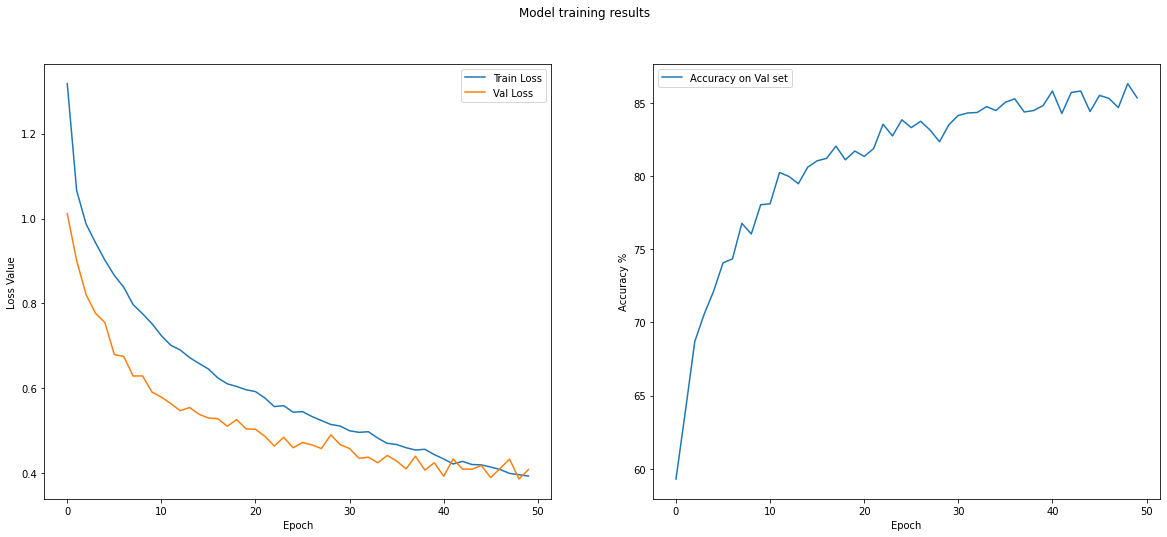

In [ ]:
# Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("Model training results")

x = range(len(train_losses))
ax1.plot(x, train_losses, label="Train Loss")
ax1.plot(x, valid_losses, label="Val Loss")
ax1.set_ylabel("Loss Value")
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(x, accuracies, label="Accuracy on Val set")
ax2.set_ylabel("Accuracy %")
ax2.set_xlabel("Epoch")
ax2.legend()

plt.show()
